In [7]:

import tensorflow as tf

import keras
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

import sys

print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("keras: ", keras.__version__)
print("tensorflow: ", tf.__version__)

Python:  3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]
pandas:  0.25.1
numpy:  1.17.2
seaborn:  0.9.0
matplotlib:  3.1.1
sklearn:  0.20.4
keras:  2.2.4
tensorflow:  2.0.0


In [8]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
filepath= './data-sample/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filepath, header=0, sep=",")
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# You will collect 20k normal and 400 abnormal records. 
# You can pick different ratios to try, but in general more normal data examples are better because you want to teach your autoencoder what normal data looks like. 
# Too much abnormal data in training will train the autoencoder to learn that the anomalies are actually normal, which goes against your goal.

df["Amount"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))

df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)

df = pd.concat([df0, df1])


In [10]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis=1), df['Class'], test_size=0.2, random_state=42)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [11]:
# Now it’s time to create a simple neural network model with just an encoder and decoder layer
# You will encode the 29 columns of the input credit card dataset into 12 features using the encoder.
# The decoder expands the 12 back into the 29 features.

# RELU, the Rectified Linear Unit, is the most commonly used activation function in deep learning models. The function returns 0 if it receives any negative input, 
# but for any positive value xx it returns that value back. 
# So it can be written as
# f(x)=max(0,x).

# Softmax, the Softmax function, outputs a vector that represents the probability distributions of a list of potential outcomes. The probabilities always add up to 1.

# More functions could be found: 
#     https://keras.io/activations/

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)
autoencoder = Model(inputArray, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 12)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [12]:
# The RMSprop optimizer is similar to the gradient descent algorithm with momentum

# A metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model
# Loss functions could be found:
#     https://keras.io/losses/

autoencoder.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mae', 'accuracy'])


In [13]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          verbose=1, 
                          shuffle=True, 
                          validation_data=(x_test, x_test),
                          callbacks=[TensorBoard(log_dir='../logs/autoencoder1')])


Train on 16320 samples, validate on 4080 samples
Epoch 1/20
16320/16320 [==============================] - 1s 63us/sample - loss: 1.4869 - mae: 0.6800 - accuracy: 0.1672 - val_loss: 1.8036 - val_mae: 0.6882 - val_accuracy: 0.3824
Epoch 2/20
16320/16320 [==============================] - 1s 54us/sample - loss: 1.4251 - mae: 0.6590 - accuracy: 0.5140 - val_loss: 1.7612 - val_mae: 0.6746 - val_accuracy: 0.5985
Epoch 3/20
16320/16320 [==============================] - 1s 52us/sample - loss: 1.4047 - mae: 0.6531 - accuracy: 0.6248 - val_loss: 1.7541 - val_mae: 0.6728 - val_accuracy: 0.6485
Epoch 4/20
16320/16320 [==============================] - 1s 53us/sample - loss: 1.4004 - mae: 0.6523 - accuracy: 0.6744 - val_loss: 1.7515 - val_mae: 0.6723 - val_accuracy: 0.6971
Epoch 5/20
16320/16320 [==============================] - 1s 52us/sample - loss: 1.3985 - mae: 0.6519 - accuracy: 0.7080 - val_loss: 1.7501 - val_mae: 0.6720 - val_accuracy: 0.7189
Epoch 6/20
16320/16320 [======================

In [14]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])


4080/4080 [==============================] - 0s 23us/sample - loss: 1.7464 - mae: 0.6715 - accuracy: 0.7846
Test loss:  1.7464226404825847
Test accuracy:  0.6714952


In [15]:
threshold=10.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)

z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
        
    error.append(y_dist)
    

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3987
           1       0.43      0.88      0.58        93

   micro avg       0.97      0.97      0.97      4080
   macro avg       0.71      0.93      0.78      4080
weighted avg       0.98      0.97      0.98      4080



In [17]:
roc_auc_score(y_test, y_label)

0.9271907894204553

In [18]:
class Visualization:
    labels = ["Normal", "Anomaly"]
    
    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)
        
        plt.figure(figsize = (10, 8))
        colors = ["orange", "green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
        
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({"error": error, "true": y}).groupby("true")
        
        figures, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                     color='r' if name == 1 else 'g', label = "Anomaly" if name == 1 else "Normal")
            
        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors='b', zorder=100, label="Threshold")
        axes.legend()
            
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
            
    
    def draw_error(self, error, threshold):
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        
        plt.hlines(threshold, xmin=0, xmax=len(error) - 1, colors='b', zorder=100, label="Threshold")
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

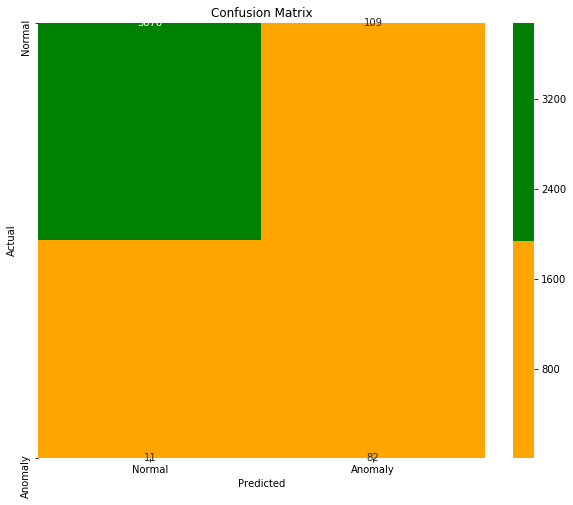

In [19]:
vis = Visualization()

vis.draw_confusion_matrix(y_test, y_label)


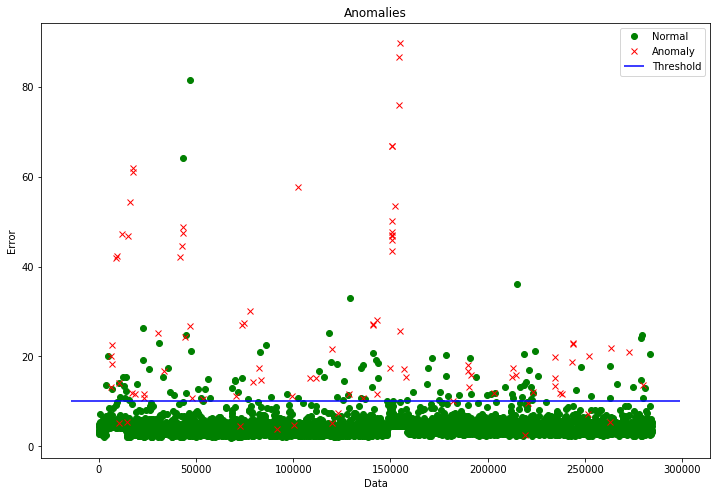

In [20]:
vis.draw_anomaly(y_test, error, threshold)